In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
## Working With Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

tools = [arxiv_tool, wiki_tool]

In [3]:
wiki_tool.invoke("who is Geoffrey Hinton?")

'Page: Geoffrey Hinton\nSummary: Geoffrey Everest Hinton (born 1947) is a British-Canadian computer scientist, cognitive scientist, and cognitive psychologist known for his work on artificial neural networks, which earned him the title "the Godfather of AI".\nHinton is University Professor Emeritus at '

In [4]:
arxiv_tool.invoke("Attention is all you need.")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [ ]:
## Langgraph Application
import os
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

llm_with_tools = llm.bind_tools(tools=tools) # wiki and arxiv


In [6]:
class State(TypedDict):
  messages: Annotated[list,add_messages]

def chatbot(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)
tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

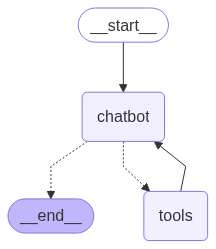

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
user_input = "Tell me about the author of attention is all you need research paper."

events = graph.stream(
     {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me about the author of attention is all you need research paper.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (sevw0zkz8)
 Call ID: sevw0zkz8
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014
================================== Ai Message ==================================

The author of the "Attention Is All You Need" research paper are eight scientists working at Google.


In [24]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (w5ps4qr5c)
 Call ID: w5ps4qr5c
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models.
